# Convolutions Visualized

In [1]:
import numpy as np
np.random.seed(42)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
if 'presentation' in plt.style.available:
    plt.style.use('presentation')

In [3]:
from keras.datasets import mnist

Using TensorFlow backend.


In [4]:
# Get the data. We don't care about the test data this time
(train_images, train_labels), _ = mnist.load_data()

In [5]:
# Put data on [0, 1] scale
train_images = train_images.astype(float) / 255

In [6]:
# Take a sample to use
sample = train_images[0]

In [7]:
# Let's say you want to find the first 3x3 square in the image:
sample[0:3, 0:3]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [8]:
# What is the center of this image? Clearly, it is (1,1). Therefore, we can 
# access this square as:
center = (1,1)

square = sample[center[0]-1:center[0]+2, center[1]-1:center[1]+2]
print(square)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [9]:
# Now, let's define a nice edge detection filter:

filt = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
print(filt)

[[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]


In [10]:
# Recall that the convolutio operation just doing element-wise multiplication
# and summing them all up:
np.sum(square * filt)

0.0

In [ ]:
# We can also compute this as the dot product (matrix multiplication) of the two
# matrices, if we flattened them into a vector of length 9:
np.dot(square.reshape(9), filt.reshape(9))

# (.ravel does this too, but reshape makes it obvious what we're doing)

In [11]:
# Let's keep it simple, and write a function that applies a filter to a section
# of an image given by a certain "center point":

def apply_filter(image, filt, center):
    image_section = image[center[0]-1:center[0]+2, center[1]-1:center[1]+2]
    return np.sum(image_section * filt)

apply_filter(sample, filt, (15, 15))

1.3137254901960782

In [12]:
# Now, the matrix of "center" points for a 28 x 28 image like an MNIST digit is
# 26 x 26, since edges can't be "center" points. We'll use no padding this time,
# which means our convolved image will be 26 x 26 as well. We'll also use a 
# stride of 1, meaning we slide the filter 1 pixel at a time.

# Initialize an empty matrix:

convolved = np.zeros((26, 26))

# For every row of pixels 1 through 27 in the original image:
for row_pixel in range(1,27):
    # and for every column of pixels 1 through 27 in the original image:
        for col_pixel in range(1,27):
            # Calculate the corresponding value in the convolved image
            # using the function we just wrote:
            convolved[row_pixel - 1, col_pixel -1] = apply_filter(sample, filt,
                                                    (row_pixel,  col_pixel))

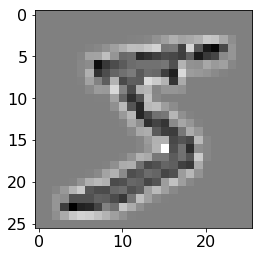

In [13]:
# Print the image using the 'imshow' plotting command with the usual settings
plt.imshow(X=convolved, cmap=plt.cm.gray_r, interpolation = "nearest");

In [14]:
# That is the heart of it. At this point I ask my students: What are we missing?
# Answer: We're missing an activation function and a bias.

In [16]:
# Define an activation function. We'll use the ReLU since it is simple, widely 
# used, and intuitive. In this MNIST case, it will zero out many pixels so that
# they're completely white.

def ReLU(Z):
    return max(0, Z)

In [17]:
# This activation function will be applied to the resulting scalar (single 
# number) of the convolution operation, with a bias. Let's re-write our function
# to incorporate an activation function and a bias:

In [18]:
def apply_filter(image, filt, center, activation=None, bias=0):
    if not activation:
        # If no activation is provided, just use the linear / identity function
        activation = lambda x: x
    image_section = image[center[0]-1:center[0]+2, center[1]-1:center[1]+2]
    convolved = np.sum(image_section * filt) + bias
    return activation(convolved)

apply_filter(sample, filt, (15, 15), activation=ReLU)

1.3137254901960782

In [19]:
# That should be good enough for now. Here is a dictionary of filters you can 
# plug and play with:
filters = {
    'random':np.random.randn(3,3),
    'edge detection':np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]),
    'horizontal':np.array([[1,1,1],[0,0,0],[-1,-1,-1]]),
    'vertical':np.array([[1,1,1],[0,0,0],[-1,-1,-1]]).T,
    'sharpen':np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]),
}

# You may find more here: http://setosa.io/ev/image-kernels/

In [20]:
def show_images(filt=np.random.randn(3,3),
                i=2, image=None, bias=0, activation=ReLU): 
    '''Function to display an image and its convolved versions, with and without
    an activation function. A 28 x 28 image along the lines of the MNIST data may
    be passed to the image parameter. Otherwise an index from the MNIST training
    data is used'''
    
    if type(i) == int:
        image = train_images[i]
    
    ####
    
    convolved_a = np.zeros((26, 26))

    for row_pixel in range(1,27):
        for col_pixel in range(1,27):
            convolved_a[row_pixel - 1,
                        col_pixel -1] = apply_filter(image, filt,
                                                             (row_pixel,
                                                              col_pixel),
                                                             activation=activation,
                                                              bias=bias)
    #####

    convolved_na = np.zeros((26, 26))

    for row_pixel in range(1,27):
        for col_pixel in range(1,27):
            convolved_na[row_pixel - 1,
                         col_pixel - 1] = apply_filter(image, filt,
                                                              (row_pixel, col_pixel),
                                                              bias=bias)

    #####
    # Here are some pooling layers, added for funsies. I'm just splitting the
    # convolved images into 2 x 2 squares and taking the max value in each square.
    
    pooled_image_a = np.zeros((13, 13))
    for row_pixel in range(0, 26, 2):
        for col_pixel in range(0, 26, 2):
            pooled_image_a[int(row_pixel/2),
                        int(col_pixel/2)] = np.amax(convolved_a[row_pixel:row_pixel+2 ,
                      col_pixel:col_pixel+2])
    ####
    
    pooled_image_na = np.zeros((13, 13))
    for row_pixel in range(0, 26, 2):
        for col_pixel in range(0, 26, 2):
            pooled_image_na[int(row_pixel/2),
                        int(col_pixel/2)] = np.amax(convolved_na[row_pixel:row_pixel+2 ,
                      col_pixel:col_pixel+2])
    
    #####
      

    fig, ax = plt.subplots(ncols=5, figsize=(15,15))
    
    ax[0].imshow(X=image, cmap=plt.cm.gray_r, interpolation = "nearest")
    ax[0].set_xlabel('Image No. {}'.format(i + 1))

    ax[1].imshow(X=convolved_a, cmap=plt.cm.gray_r, interpolation = "nearest")
    ax[1].set_xlabel('W/ Activation')

    ax[2].imshow(X=convolved_na, cmap=plt.cm.gray_r, interpolation = "nearest")
    ax[2].set_xlabel('W/o Activation')
    
    ax[3].imshow(X=pooled_image_a, cmap=plt.cm.gray_r, interpolation = "nearest")
    ax[3].set_xlabel('Pooled w/ Act')
    ax[4].imshow(X=pooled_image_na, cmap=plt.cm.gray_r, interpolation = "nearest")
    ax[4].set_xlabel('Pooled w/o Act')
    plt.show();

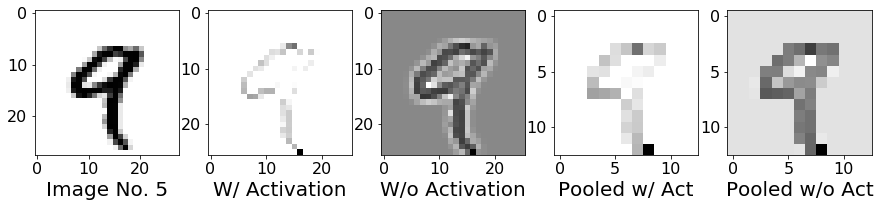

In [21]:
convolved = show_images(filt=filters['edge detection'],
                        i=4, bias=-2)

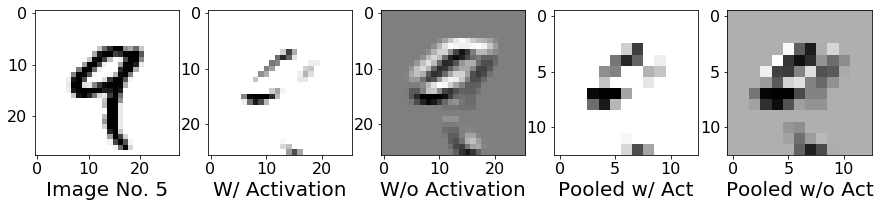

In [22]:
convolved = show_images(filt=filters['horizontal'],
                        i=4, bias=-1)